In [ ]:
! pip install tabulate
! pip install
! pip install nltk
! pip install textblob

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
import sys
sys.path.append("c:/Users/DENISA/Documents/3A/ML for trading/coding/skfin")

In [3]:
from skfin.plot import line

**Expliquer ce qu'on veut faire: la problématique etc...***

In [11]:

import requests

# URL for downloading the ECB speeches CSV
csv_url = "https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?e71dfd40f5555777ae06473522d191b4"

# Send a GET request to download the file
response = requests.get(csv_url)


if response.status_code == 200:
    # Save the CSV content to a file
    with open('ecb_speeches.csv', 'wb') as file:
        file.write(response.content)
    print("Download successful, saved as 'ecb_speeches.csv'")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")
speeches = pd.read_csv("ecb_speeches.csv", header=0, sep='|')

Download successful, saved as 'ecb_speeches.csv'


In [180]:

speeches = speeches[speeches['date'] <= '2024-10-30'].reset_index(drop=True).dropna() # the database is continously updated, so we restrain our analysis at dates previous to 30/10/2024

In [181]:
speeches

,date,speakers,title,subtitle,contents
0,2024-10-28,Frank Elderson,Transcript of video recording for Finance and ...,"Contribution by Frank Elderson, Member of the ...",SPEECH Transcript of video recording for Fi...
1,2024-10-28,Luis de Guindos,Monetary policy and financial stability in the...,"Introductory remarks by Luis de Guindos, Vice-...",SPEECH Monetary policy and financial stabil...
2,2024-10-25,Christine Lagarde,IMFC Statement,"Statement by Christine Lagarde, President of t...",SPEECH IMFC Statement Statement by Chris...
3,2024-10-24,Philip R. Lane,Underlying inflation: an update,"Speech by Philip R. Lane, Member of the Execut...",SPEECH Underlying inflation: an update Sp...
4,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"Speech by Christine Lagarde, President of the ...",SPEECH Lessons from Ljubljana in uncertain ...
...,...,...,...,...,...
2725,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2726,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2727,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2728,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


#I - Statistiques Descriptives

In [182]:
# Nous nous intéressons uniquement aux discours de la BCE ainsi qu'à leurs dates: nous analyserons les discours afin de déterminer ceux qui ont trait à
# l'environnement grâce au LLM, quant aux dates, nous les utiliserons afin de pouvoir analyser voir leur l'effet des discours sur les cours
# des actions d'entreprises de pétrole et de gaz sur un intervalle de temps
# déterminé
speeches_contents_date=speeches[['date','contents']]

In [183]:
speeches_contents_date

,date,contents
0,2024-10-28,SPEECH Transcript of video recording for Fi...
1,2024-10-28,SPEECH Monetary policy and financial stabil...
2,2024-10-25,SPEECH IMFC Statement Statement by Chris...
3,2024-10-24,SPEECH Underlying inflation: an update Sp...
4,2024-10-16,SPEECH Lessons from Ljubljana in uncertain ...
...,...,...
2725,1997-05-13,The European Central Bank: independent and a...
2726,1997-04-30,The operation of monetary policy in stage th...
2727,1997-04-22,Convergence and the role of the European Cen...
2728,1997-03-10,Securing the benefits of EMU Address by Al...


In [135]:
# La proportion de NaN dans chacune des colonnes
speeches_contents_date.isna().sum()/len(speeches_contents_date)

date        0.0
contents    0.0
dtype: float64

In [137]:
# Le nombre de caractères moyen par discours
speeches_contents_date.loc[:, 'length'] = speeches_contents_date['contents'].str.len()
average_length = speeches_contents_date['length'].mean()
print(average_length)


19697.85238095238


In [139]:
# Le nombre de caractères moyen par phrase du discours : cela nous sera utile plus tard dans l'utilisation du LLM
speeches_contents_date.loc[:,'length_per_stc'] = speeches_contents_date.loc[:,'contents'].str.split('.').str.len()
average_length_stc = speeches_contents_date['length_per_stc'].mean()
print(average_length_stc)

146.52527472527473


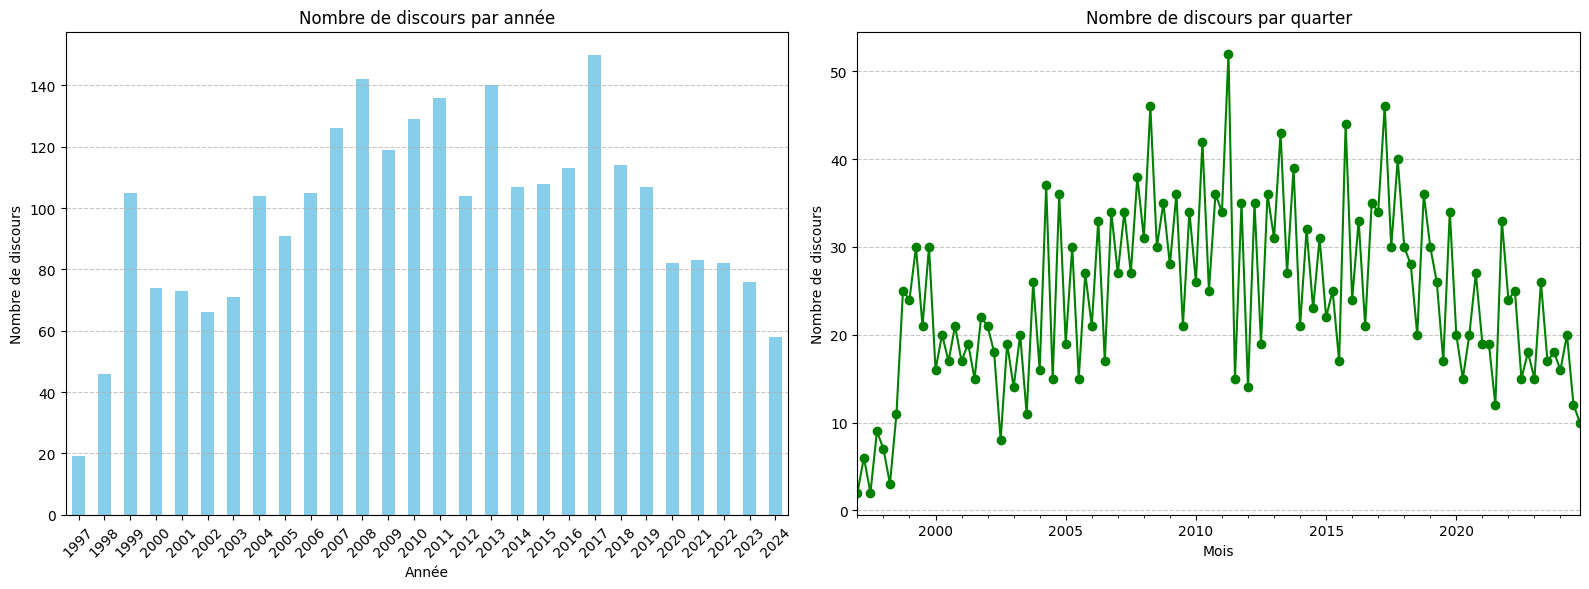

In [142]:
# La fréquence des speechs par mois et par années
#Modifier en nombre de speechs par quarter
speeches_contents_date['date'] = pd.to_datetime(speeches_contents_date['date'])
speeches_contents_date.loc[:,'year'] = speeches_contents_date['date'].dt.year
speeches_contents_date.loc[:,'month'] = speeches_contents_date['date'].dt.month
speeches_per_year = speeches_contents_date.groupby('year').size()
# Group speeches by quarter
speeches_contents_date['year_quarter'] = speeches_contents_date['date'].dt.to_period('Q')
speeches_per_quarter = speeches_contents_date.groupby('year_quarter').size()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
speeches_per_year.plot(kind='bar', color='skyblue', ax=axes[0], title='Nombre de discours par année')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Nombre de discours')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
speeches_per_quarter.plot(kind='line', marker='o', color='green', ax=axes[1], title='Nombre de discours par quarter')
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Nombre de discours')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#II - Prédiction des discours à caractère environnemental

In [143]:
# Les discours sous formar Numpy Array
speeches_contents=speeches_contents_date['contents'].values

In [ ]:
speeches_contents[2]

"  SPEECH  IMFC Statement    Statement by Christine Lagarde, President of the ECB, at the fiftieth meeting of the International Monetary and Financial Committee IMF Annual Meetings, 25 October 2024   Introduction  Since our last meeting in April, the global growth outlook has remained broadly unchanged. While global growth is projected to expand at a moderate pace , risks to the outlook have shifted to the downside, reflecting rising economic policy uncertainty against a backdrop of heightened geopolitical tensions. Global headline inflation continues to recede amid falling energy prices, the normalisation of supply conditions and still tight monetary policy. In October the Governing Council lowered the three key ECB interest rates by 25 basis points. The decision to lower the deposit facility rate – the rate through which it steers the monetary policy stance – reflects the Governing Council’s updated assessment of the inflation outlook, the dynamics of underlying inflation and the str

**Présentation du LLM (d'où il vient, ce qu'il fait, comment se fait le calcule du niveau de confidence...)**

In [131]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, padding=True, max_length=512)

**La particularité de notre LLM est que ce dernier ne peut process que des textes ayant un nombre de caractères inférieur ou égale à 520. Au vu de la longueur des discours dans notre database, nous devons split les discours. Une première méthode a été de split les discours par phrases, de catégoriser les phrases puis d'utiliser le critère majoritaire pour catégoriser un discours. Nous commes conscientes que celà peut entrainer des biais, notamment le biais de perte de contexte, car une phrase isolée peut ne pas suffire à capturer l'intention ou la thématique générale du discours. Par exemple, une phrase comme "L'impact des émissions de CO2 sur l'économie est indéniable" pourrait être catégorisée comme environnementale, alors que la phrase suivante, "Cependant, les priorités actuelles restent centrées sur la stabilité monétaire", modifie le sens global en suggérant que l'environnement n'est pas une priorité.**

In [ ]:
#Eviter de tourner le code suivant qui prend plusieurs heures, le résultat est mis en csv juste après
var_factice=0


In [ ]:
if var_factice==1:

  # Connecter Google Drive
  drive.mount('/content/drive')

  # Définir le dossier où sauvegarder les fichiers dans Google Drive
  checkpoint_folder = "/content/drive/MyDrive/Checkpoints/"
  !mkdir -p $checkpoint_folder  # Créer le dossier s'il n'existe pas

  # Initialisation des variables
  final_labels = np.zeros(2730, dtype=str)
  confidence_labels = np.zeros(2730, dtype=float)
  labels = np.zeros(2730, dtype=int)

  checkpoint_interval = 100  # Sauvegarde tous les 100 itérations

  for i in range(2730):
      print(f"Processing {i+1}/{2730}")
      text = speeches_contents[i]
      chunks = text.split(".")

      results = []
      for chunk in chunks:
          if chunk.strip():
              result = nlp(chunk.strip())  # Appel à votre modèle NLP
              results.append(result)

      if results:
          labels_list = [result[0]['label'] for result in results]
          final_label = max(set(labels_list), key=labels_list.count)
          final_labels[i] = final_label
          confidence = np.mean([result[0]['score'] for result in results])
          confidence_labels[i] = confidence
      else:
          final_labels[i] = "UNKNOWN"
          confidence_labels[i] = 0.0

      labels[i] = i

      # Sauvegarde périodique
      if (i + 1) % checkpoint_interval == 0 or i == 2729:  # Tous les 100 itérations ou à la fin
          df = pd.DataFrame({
              "ID": labels[:i + 1],
              "Final Label": final_labels[:i + 1],
              "Confidence": confidence_labels[:i + 1]
          })
          partial_file = f"{checkpoint_folder}/results_checkpoint_{i+1}.csv"
          df.to_csv(partial_file, index=False)
          print(f"Checkpoint saved to Google Drive: {partial_file}")


#III-Statistiques descriptives des résultats de la catégorisation

In [174]:
speech_categ=pd.read_csv('speeches_categorized.csv',sep='\t')

In [175]:
speech_categ

,ID,Final Label,Confidence
0,0,S,0.797270
1,1,N,0.827785
2,2,N,0.877081
3,3,N,0.810546
4,4,S,0.829582
...,...,...,...
2725,2725,N,0.776906
2726,2726,N,0.812642
2727,2727,N,0.879239
2728,2728,N,0.846478


In [129]:
speech_categ.isna().sum()

ID             0
Final Label    0
Confidence     0
dtype: int64

In [176]:
speech_categ['Final Label'].value_counts()

Final Label
N    1892
S     779
G      31
E      27
U       1
Name: count, dtype: int64

In [177]:
speech_categ=speech_categ.drop(speech_categ[speech_categ['Final Label']=='U'].index)

In [186]:
speeches_labelized = speeches.join(speech_categ,how='left')

In [187]:
speeches_labelized

,date,speakers,title,subtitle,contents,ID,Final Label,Confidence
0,2024-10-28,Frank Elderson,Transcript of video recording for Finance and ...,"Contribution by Frank Elderson, Member of the ...",SPEECH Transcript of video recording for Fi...,0.0,S,0.797270
1,2024-10-28,Luis de Guindos,Monetary policy and financial stability in the...,"Introductory remarks by Luis de Guindos, Vice-...",SPEECH Monetary policy and financial stabil...,1.0,N,0.827785
2,2024-10-25,Christine Lagarde,IMFC Statement,"Statement by Christine Lagarde, President of t...",SPEECH IMFC Statement Statement by Chris...,2.0,N,0.877081
3,2024-10-24,Philip R. Lane,Underlying inflation: an update,"Speech by Philip R. Lane, Member of the Execut...",SPEECH Underlying inflation: an update Sp...,3.0,N,0.810546
4,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"Speech by Christine Lagarde, President of the ...",SPEECH Lessons from Ljubljana in uncertain ...,4.0,S,0.829582
...,...,...,...,...,...,...,...,...
2725,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...,2725.0,N,0.776906
2726,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...,2726.0,N,0.812642
2727,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...,2727.0,N,0.879239
2728,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...,2728.0,N,0.846478


# Sentiment-Topic Correlation Analysis

In this step, we aim to explore the relationship between sentiment and topic labels (Environment, Governance, Social, None) within the dataset. By combining sentiment analysis with topic classification, we can identify whether specific topics are discussed in a more positive, negative, or neutral manner. We will use VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from NLTK (Natural Language Toolkit) and TextBlob, in order to make a comparison. We are interested not necessarily in comparing the score, but the order. (For instance, if the two models consider Environment speeches more positive than Social speeches.)


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm import tqdm
from textblob import TextBlob

In [191]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [192]:
tqdm.pandas() 
speeches_labelized['Sentiment_blob'] = speeches_labelized['contents'].progress_apply(get_sentiment)

100%|██████████| 2730/2730 [00:40<00:00, 68.05it/s] 


In [195]:
analyzer = SentimentIntensityAnalyzer()
tqdm.pandas()  # Enable tqdm progress bar for pandas apply
# Compound score ranges from -1 to 1.
speeches_labelized['Sentiment_nltk'] = speeches_labelized['contents'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound']) 

100%|██████████| 2730/2730 [06:30<00:00,  6.99it/s]


In [ ]:
# compute the average sentiment for speeches with a specific label
grouped_sentiment_blob = speeches_labelized.groupby('Final Label')['Sentiment_blob'].mean()
grouped_sentiment_nltk = speeches_labelized.groupby('Final Label')['Sentiment_nltk'].mean()

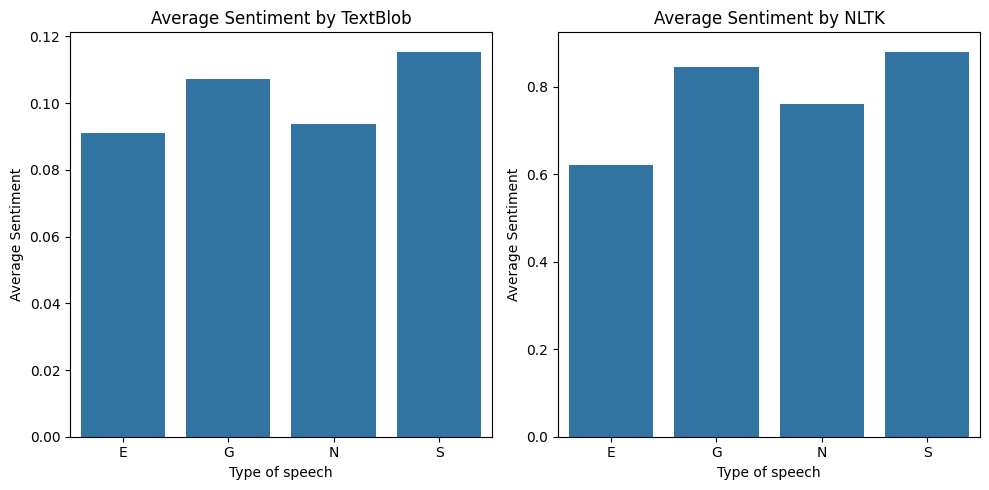

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


sns.barplot(x=grouped_sentiment_blob.index, y=grouped_sentiment_blob.values, ax=axes[0])
axes[0].set_title('Average Sentiment by TextBlob')
axes[0].set_xlabel('Type of speech')
axes[0].set_ylabel('Average Sentiment')

# Plot the second barplot on the second axis
sns.barplot(x=grouped_sentiment_nltk.index, y=grouped_sentiment_nltk.values, ax=axes[1])
axes[1].set_title('Average Sentiment by NLTK')
axes[1].set_xlabel('Type of speech')
axes[1].set_ylabel('Average Sentiment')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

We observe that the environment-related speeches have a consistent more negative tone that the others. In order to understand better why, we look at the topics for each type of speech.

# Topics of speeches
In this section, we will extract the most important features from the speeches using TF-IDF. For green speeches, we will use bigrams, as suggested in the paper by Martin Feldkircher & Viktoriya Teliha (2024), "Speeches in the Green: The Political Discourse of Green Central Banking," CAMA Working Papers 2024-03, as bigrams appear to be more appropriate for green speeches.

In [220]:
vectorizer = TfidfVectorizer(
 stop_words="english",
 min_df=5,
 max_df=0.8,
 ngram_range=(2,2),
 token_pattern=r"\b[a-zA-Z]{3,}\b",
 )

In [ ]:
def extract_features(speech_type):
    """
    This function extracts the most important features (TF-IDF scores) from the speeches of a specific type, 
    calculates the average TF-IDF score for each feature, and returns them sorted in descending order.

    Parameters:
    -----------
    speech_type : str
        The label/category of the speeches to analyze (e.g., 'Green', 'Non-Green', etc.).

    Returns:
    --------
    pandas.Series
        A sorted series containing the average TF-IDF scores for each feature (word or n-gram), 
        where the index represents the feature name and the values represent the corresponding average TF-IDF score.
    """


    df=speeches_labelized[speeches_labelized['Final Label']==speech_type]
    df=df.reset_index(drop=True)
    X_ = vectorizer.fit_transform(df['contents'].values)
    cols = vectorizer.get_feature_names_out()
    X_tfidf = pd.DataFrame(np.log1p(X_.toarray()), index=df.index, columns=cols)

    return X_tfidf.mean().sort_values(ascending=False)

We plot the 6 most important features for each type of speech.

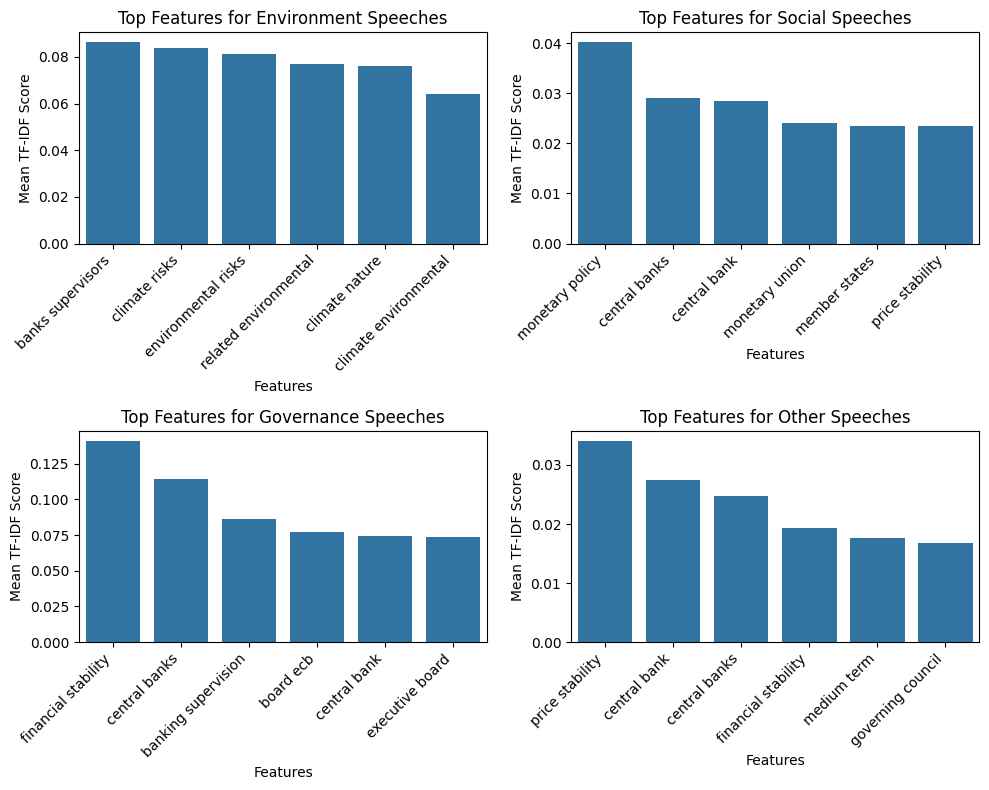

In [224]:


speech_types = ['E', 'S', 'G', 'N']
speech_dictionary={'E':'Environment', 'S':'Social', 'G':'Governance', 'N':'Other'}


fig, axes = plt.subplots(2, 2, figsize=(10, 8))


for i, speech_type in enumerate(speech_types):
    
    top_features = extract_features(speech_type).head(6)
    
    
    ax = axes[i//2, i%2]
    
    
    sns.barplot(x=top_features.index, y=top_features.values, ax=ax)
    
    
    ax.set_title(f'Top Features for {speech_dictionary[speech_type]} Speeches')
    ax.set_xlabel('Features')
    ax.set_ylabel('Mean TF-IDF Score')
    ax.set_xticks(range(len(top_features)))
    ax.set_xticklabels(top_features.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


We might explain why the environment speeches were classified as more negative by noting that some of their top features include terms related to risk, such as "climate risk" and "environmental risk."

# Influence of Green Speeches on Green ETFs

In [ ]:
green_speeches=speeches_labelized[speeches_labelized['Final Label']=='E']
green_speeches=green_speeches.reset_index(drop=True)
green_speeches

In [253]:
green_etf=yf.download('ICLN')
fossil_etf=yf.download('XOP',start='2008-06-25')# pour avoir la meme date de début que le green etf

data_etfs = pd.DataFrame({
    'ETF_green_Close': green_etf['Adj Close'].values.flatten(),  # Flatten to 1D
    'ETF_fossil_Close': fossil_etf['Adj Close'].values.flatten(),
    'ETF_green_Volume': green_etf['Volume'].values.flatten(),
    'ETF_fossil_Volume': fossil_etf['Volume'].values.flatten(),
}).dropna()
data_etfs.index=fossil_etf.index
data_etfs['Price Spread']=data_etfs['ETF_green_Close']- data_etfs['ETF_fossil_Close']
data_etfs['Return ETF Green'] = data_etfs['ETF_green_Close'].pct_change()
data_etfs['Return ETF Fossil'] = data_etfs['ETF_fossil_Close'].pct_change()
data_etfs['Return Spread']=data_etfs['Return ETF Green']-data_etfs['Return ETF Fossil']
data_etfs.index = data_etfs.index.date


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


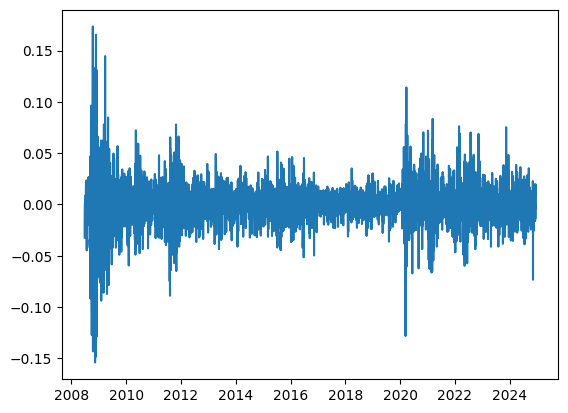

In [101]:
plt.plot(data_etfs['Return ETF Green'])

In [254]:

# Create a new column in data_etfs indicating if the date is in green_speeches
# Convert 'date' column in green_speeches to datetime.date (just date part)
green_speeches.loc[:, 'date'] = pd.to_datetime(green_speeches['date']).dt.date

# Step 3: Create the 'Green Speech' column
data_etfs['Green Speech'] = data_etfs.index.isin(green_speeches['date']).astype(int)

In [255]:
# Normaliser les returns
data_etfs['Return ETF Green']= data_etfs['Return ETF Green'].div(data_etfs['Return ETF Green'].ewm(252).std()).asfreq("B")
data_etfs['Return ETF Fossil']= data_etfs['Return ETF Fossil'].div(data_etfs['Return ETF Fossil'].ewm(252).std()).asfreq("B")
data_etfs['Return Spread']= data_etfs['Return Spread'].div(data_etfs['Return Spread'].ewm(252).std())

In [256]:
# drop the first two rows with NaN
data_etfs=data_etfs.iloc[2:]

In [257]:
def plot_returns_comparaison(data,asset):
    """
    Plots the distribution of returns for a given asset on green speech days vs normal days.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing data on ETFs.
    asset (str): The asset name ('ETF Green', 'ETF Fossil', 'Spread') for which the return comparison is to be plotted"""


    bins = np.linspace(-10, 10, 50)

    plt.hist(
    data['Return '+asset][data['Green Speech'] == 1], bins, density=True, alpha=0.5,label="Green Speeches days",)

    plt.hist(
    data['Return '+asset][data['Green Speech'] == 0], bins, density=True, alpha=0.5, label="Normal days")
    plt.legend(loc="upper right")
    plt.title(f'Returns of {asset}')
    plt.show()

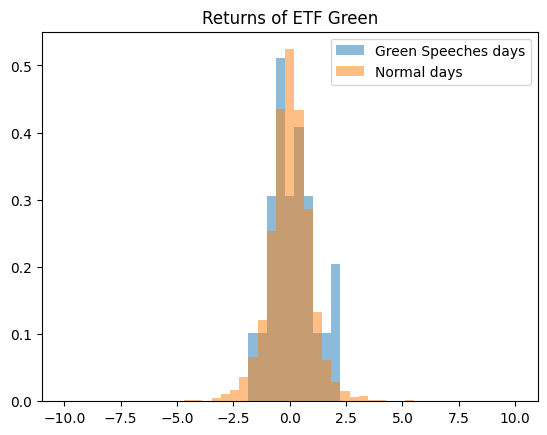

In [258]:

plot_returns_comparaison(data_etfs,'ETF Green')  



# Cumulative returns from being long on the market

In [259]:

data_post=data_etfs[green_speeches['date'][26]:]


In [263]:
def create_df_green_returns(data, asset):

    '''Generates a DataFrame with two columns: "Green Speech" and "Not Green Speech".
    The index includes all dates starting from the first Green Speech on 17/04/2019.
    The "Green Speech" column contains the return values (for a given asset) on dates corresponding to Green Speeches, with NaN elsewhere.
    Conversely, the "Not Green Speech" column contains the return values on dates corresponding to non-Green Speeches, with NaN elsewhere.
    Parameters:
        data (pd.DataFrame): The input DataFrame containing data on ETFs.
        asset (str): The asset for which to calculate returns. Must be one of "ETF Green", "ETF Fossil", "Spread".
    
    '''

    valid_assets = ["ETF Green", "ETF Fossil", "Spread"]
    if asset not in valid_assets:
        raise ValueError(f"Invalid asset. Please choose one of the following: {valid_assets}")

    df=pd.DataFrame()
    df.index=data.index
    df['Green Speech'] = data.apply(lambda x: x['Return '+asset] if x['Green Speech'] == 1 else None, axis=1)
    df['Not Green Speech'] = data.apply(lambda x: x['Return '+asset] if x['Green Speech'] == 0 else None, axis=1)
    
    return df


In [264]:
df=create_df_green_returns(data=data_post, asset='ETF Green')

In [265]:
df

,Green Speech,Not Green Speech
2019-04-17,0.466168,NaN
2019-04-18,NaN,-0.278817
2019-04-22,NaN,0.000000
2019-04-23,NaN,0.841207
2019-04-24,NaN,-0.463872
...,...,...
2024-12-05,NaN,0.050382
2024-12-06,NaN,-0.252195
2024-12-09,NaN,1.214155
2024-12-10,NaN,-0.794372


In [141]:
def plot_cumulative_return(data, asset):
    
    df=create_df_green_returns(data=data, asset=asset)
    line(
    df
    .fillna(0)
    .assign(ALL=lambda x: x.sum(axis=1)),
    cumsum=True,
    legend_sharpe_ratio=False,
    title="Cumulative return from being long the market for the asset: "+asset ,
)

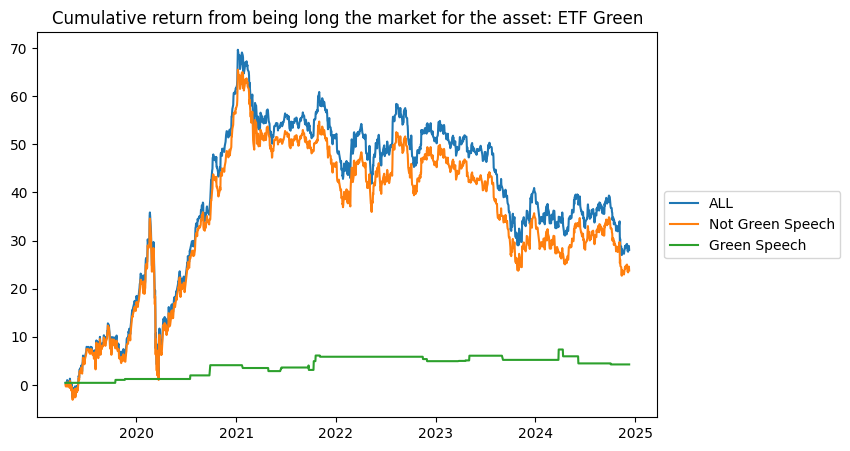

In [146]:
plot_cumulative_return(data=data_post, asset='ETF Green')

In [266]:
# Get the descriptive statistics for 'Return ETF Green'
description = data_post['Return ETF Green'][data_etfs['Green Speech'] == 0].describe()

# Print summary in a formatted table
print(tabulate(description.items(), headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒══════════╤══════════════╕
│ Metric   │        Value │
╞══════════╪══════════════╡
│ count    │ 1400         │
├──────────┼──────────────┤
│ mean     │    0.0170084 │
├──────────┼──────────────┤
│ std      │    1.06255   │
├──────────┼──────────────┤
│ min      │   -8.20922   │
├──────────┼──────────────┤
│ 25%      │   -0.541659  │
├──────────┼──────────────┤
│ 50%      │   -0.0234827 │
├──────────┼──────────────┤
│ 75%      │    0.59086   │
├──────────┼──────────────┤
│ max      │    5.36704   │
╘══════════╧══════════════╛


We notice that the average return is positive on days of Green Speeches. We want to investigate further if a Green Speech has a positive effect on the return in the following days.

# Abnormal returns around speech dates

In [61]:
green_speech_dates = data_etfs[data_etfs['Green Speech'] == 1].index
green_speech_dates

Index([2019-04-17, 2019-10-17, 2019-11-21, 2020-07-17, 2020-09-28, 2021-01-25,
       2021-04-29, 2021-06-14, 2021-06-16, 2021-09-23, 2021-09-24, 2021-10-12,
       2021-10-19, 2021-11-04, 2022-11-16, 2022-12-01, 2023-03-27, 2023-04-21,
       2023-05-05, 2023-09-05, 2024-03-27, 2024-04-12, 2024-06-07, 2024-10-04],
      dtype='object')

In [85]:
def compute_rolling_averages(data,window):
    '''
    Computes average historic returns over a specified window (measured in business days).
    
    Parameters:
    - data (DataFrame): Input DataFrame containing ETF returns.
    - window (int): The size of the rolling window for calculating averages.
    
    Returns:
    - DataFrame: A new DataFrame with columns for rolling averages of green and fossil ETF returns,
                 as well as the rolling average of the spread between the two.
    '''
    data=data.copy()
    data['Average ETF Green'] = data['Return ETF Green'].rolling(window=window, min_periods=1).mean()
    data['Average ETF Fossil'] = data['Return ETF Fossil'].rolling(window=window, min_periods=1).mean()
    data['Average Spread'] = data['Return Spread'].rolling(window=window, min_periods=1).mean()
    return data

data_etfs_averages=compute_rolling_averages(data_etfs,window=20)


In [86]:
def calculate_ar(data, event_date, b, asset):
    """
    Calculate Abnormal Returns (AR) and Cumulative Abnormal Returns (CAR) for a given event window 
    in business days.

    Parameters:
    - data (DataFrame): Input DataFrame containing ETF returns and rolling averages.
    - event_date (datetime): The event date from which the AR and CAR calculation begins.
    - b (int): The number of business days to include in the event window.
    - asset (str): Specifies the asset type ('Green', 'Fossil', or other asset names).

    Returns:
    - DataFrame: A DataFrame containing columns:
        - 'Abnormal Return': The difference between the actual return and the expected return.
        - 'Cumulative Abnormal Return': The cumulative sum of abnormal returns over the event window.
    """
    # Define the start and end dates for the event window
    start_date = event_date  # Start date is the event date
    end_date = event_date + pd.offsets.BDay(b)  # End date is event_date plus b business days
    
    # Extract data for the specified event window
    window_data = data[(data.index >= start_date) & (data.index <= end_date.date())].copy()
    
    # Compute Abnormal Returns (AR) based on the specified asset
   
    window_data['Abnormal Return'] = window_data['Return ' + asset] - window_data['Average ' + asset]
    
    # Calculate Cumulative Abnormal Returns (CAR)
    window_data['Cumulative Abnormal Return'] = window_data['Abnormal Return'].cumsum()
    
    return window_data[['Abnormal Return', 'Cumulative Abnormal Return']]



In [87]:
def abnormal_returns(data, event_window, asset):
    """
    Compute Abnormal Returns (AR) and Cumulative Abnormal Returns (CAR) 
    for a specified event window around green speech dates.

    Parameters:
    - data (DataFrame): Input DataFrame containing ETF returns, rolling averages, 
      and a 'Green Speech' column indicating event dates.
    - event_window (int): The number of business days forward from each event date to include in the window.
    - asset (str): Specifies the asset type ('Green', 'Fossil', or other asset names).

    Returns:
    - DataFrame: A concatenated DataFrame containing AR and CAR for all green speech events 
      within the specified window, indexed by the relevant business dates.
    """
    # Extract green speech dates
    green_speech_dates = data[data['Green Speech'] == 1].index

    # Initialize a list to store results for each event
    car_results = []

    # Calculate AR and CAR for each green speech date
    for date in green_speech_dates:
        ar_car_result = calculate_ar(data, date, event_window, asset)
        car_results.append(ar_car_result)

    # Combine results into a single DataFrame
    car_df = pd.concat(car_results)

    return car_df



In [101]:
car_df=abnormal_returns(data=data_etfs_averages,event_window=5,asset='ETF Green')

In [ ]:
def plot_abnormal_returns(data,event_window,asset,car):
    """
    Plots the abnormal returns or cumulative abnormal returns of a specified asset around the event of a green speech.
    
    Parameters:
    data (DataFrame): The dataset containing asset returns and other relevant information such as the date of green speeches.
    event_window (int): The number of days around the green speech to analyze (e.g., 5 for a 5-day window).
    asset (str): The asset to analyze (e.g., "Green" or "Fossil").
    car (bool): A boolean that determines whether to plot "Abnormal Returns" (False) or "Cumulative Abnormal Returns" (True)."""

    df=abnormal_returns(data=data,event_window=event_window,asset=asset)
    if car==False:
        plt.hist(df['Abnormal Return'], density=True)
        plt.title(f'Abnormal Returns of the {asset} for the {event_window} days after a Green Speech')
    if car==True:
        plt.hist(df.iloc[::event_window]['Cumulative Abnormal Return'],density=True) # the cumulative abnormal return at the end of the event_windox
        plt.title(f'Cumulative Abnormal Returns of the {asset} over a 5 days window after a Green Speech')
    

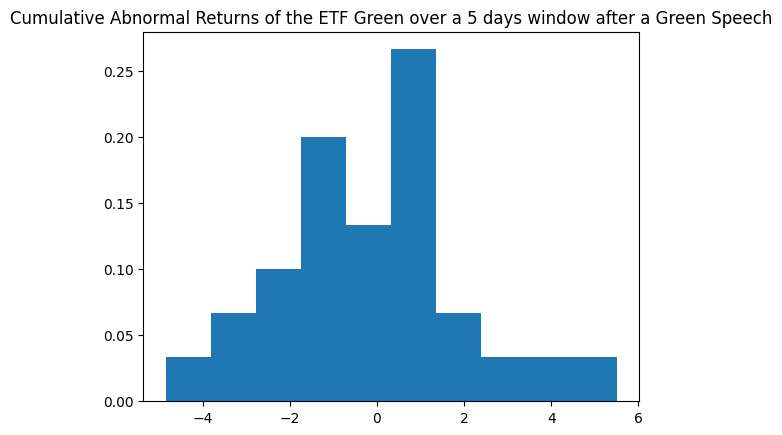

In [116]:
plot_abnormal_returns(data_etfs_averages,event_window=5, asset='ETF Green',car=True)

In [80]:
car_df['Abnormal Return'].describe()

count    141.000000
mean       0.000703
std        0.725572
min       -1.737501
25%       -0.460295
50%       -0.073953
75%        0.445223
max        1.890360
Name: Abnormal Return, dtype: float64

In [33]:
car_df['Abnormal Return'].describe()

count    141.000000
mean      -0.031069
std        0.836196
min       -3.047612
25%       -0.616000
50%       -0.022666
75%        0.453415
max        2.087042
Name: Abnormal Return, dtype: float64

In [110]:
car_df.iloc[::5]['Cumulative Abnormal Return'].describe()

count    29.000000
mean     -0.098011
std       2.139334
min      -4.848033
25%      -1.280974
50%      -0.022671
75%       0.818985
max       5.499743
Name: Cumulative Abnormal Return, dtype: float64

# Volume